In [15]:
%matplotlib inline
import numpy as np
from PIL import Image
from keras.models import model_from_json
from keras.optimizers import RMSprop
from mask_utils import get_images, get_input_prediction_tiles, image_from_tiles
from glob import glob

In [17]:
class image_generator(object):
    def __init__(self, X, Y, batch_size, channels):
        self.X  = X
        self.Y  = Y
        self.bs = batch_size
        self.channels = channels
        self.i  = 0
    def __next__(self):
        xs = self.X[self.i:self.i+self.bs]
        ys = self.Y[self.i:self.i+self.bs]
        # convert 32,64,64,1 -> 32,4096,1
        ys = ys.reshape(len(ys),-1,self.channels)
        self.i = (self.i + self.bs) % self.X.shape[0]
        return xs, ys

def get_score_mask_images(path):
    score_image_names = glob(path+'/diced_score*png')
    mask_image_names = glob(path+'/diced_mask*png')
    score_image_names.sort()
    mask_image_names.sort()
    score_images = np.stack([np.array(Image.open(fn)) for fn in score_image_names])
    mask_images = np.stack([np.array(Image.open(fn))//255 for fn in mask_image_names])
    score_images.shape = score_images.shape + (1,)
    mask_images.shape = mask_images.shape + (1,)
    assert(score_images.shape == mask_images.shape)
    return score_images, mask_images

Load the model & weights that were most-recently created by train_mask_model.py.

In [16]:
model_file   = 'data/results/model_180106.json'
weights_file = 'data/results/mask_weights_180106_143329.h5'

#model_file   = 'data/results/model_171223.json'
#weights_file = 'data/results/mask_weights_171223_134224.h5'
# very interesting comparison.  Nomaxpool is WAY better than maxpool-enabled.
#model_file   = 'data/results/model_171112.json'
#weights_file = 'data/results/mask_weights_171112_123000.h5'

with open(model_file,"r") as f:
    json_string = f.read()
model = model_from_json(json_string)
model.load_weights(weights_file)

Create a set of images to check vs. the model.

In [23]:
train_score_images, train_mask_images = get_score_mask_images('data/train')
valid_score_images, valid_mask_images = get_score_mask_images('data/valid')
test_score_images, test_mask_images = get_score_mask_images('data/valid')
num_train_images,rows,cols,channels = train_score_images.shape
num_valid_images,_,_,_ = valid_score_images.shape
num_test_images,_,_,_ = test_score_images.shape
batch_size = 32
train_generator = image_generator(train_score_images, train_mask_images,
                                  batch_size, channels)
valid_generator = image_generator(valid_score_images, valid_mask_images,
                                  batch_size, channels)
test_generator = image_generator(test_score_images, test_mask_images,
                                  batch_size, channels)

Compile the model & then evaluate it vs the validation & test sets. 
The validation score should match what you saw in the output of your training log.

In [24]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=RMSprop(1e-3),
              metrics=["accuracy"])

In [37]:
# does this match your expectation?
model.evaluate_generator(valid_generator,steps=num_valid_images//batch_size)

[0.0053708083116191319, 0.99939882989967188]

In [38]:
# here are some images that were never seen by the model before.
# we hope they get a score similar to the validation set.
model.evaluate_generator(test_generator,steps=num_test_images//batch_size)

[0.005418685425822853, 0.99938681532227547]

Now loop through the test cases, predicting the images and storing them as mask png files.

In [39]:
#for base_name in ['chromatic','chromatic_piano','gen_one','gen_two','twinkle']:
for base_name in ['chromatic','gen_one','gen_two','twinkle']:
    print(f"predicting {base_name}")
    score_image, mask_image = get_images(base_name)
    input_tiles = get_input_prediction_tiles(score_image)
    pred_tiles = model.predict(input_tiles)
    pred_one = image_from_tiles(score_image.width, score_image.height, 
                                input_tiles.shape[0], pred_tiles, 1)
    #pred_one
    with open(f"data/results/pred_mask_{base_name}.png",'wb') as f:
        pred_one.save(f)

predicting chromatic
predicting gen_one
predicting gen_two
predicting twinkle


Compare the predicted vs. expected images... You'll probably want to do this outside of Jupyter notebook...

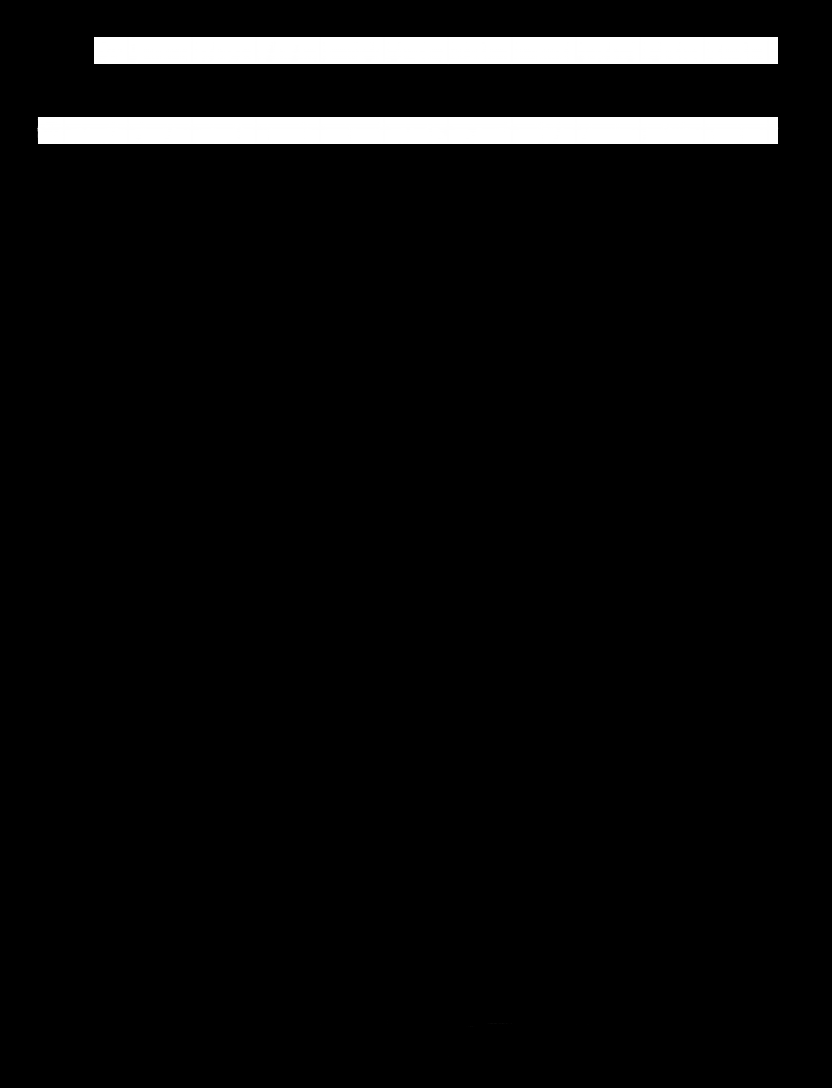

In [40]:
pred_one

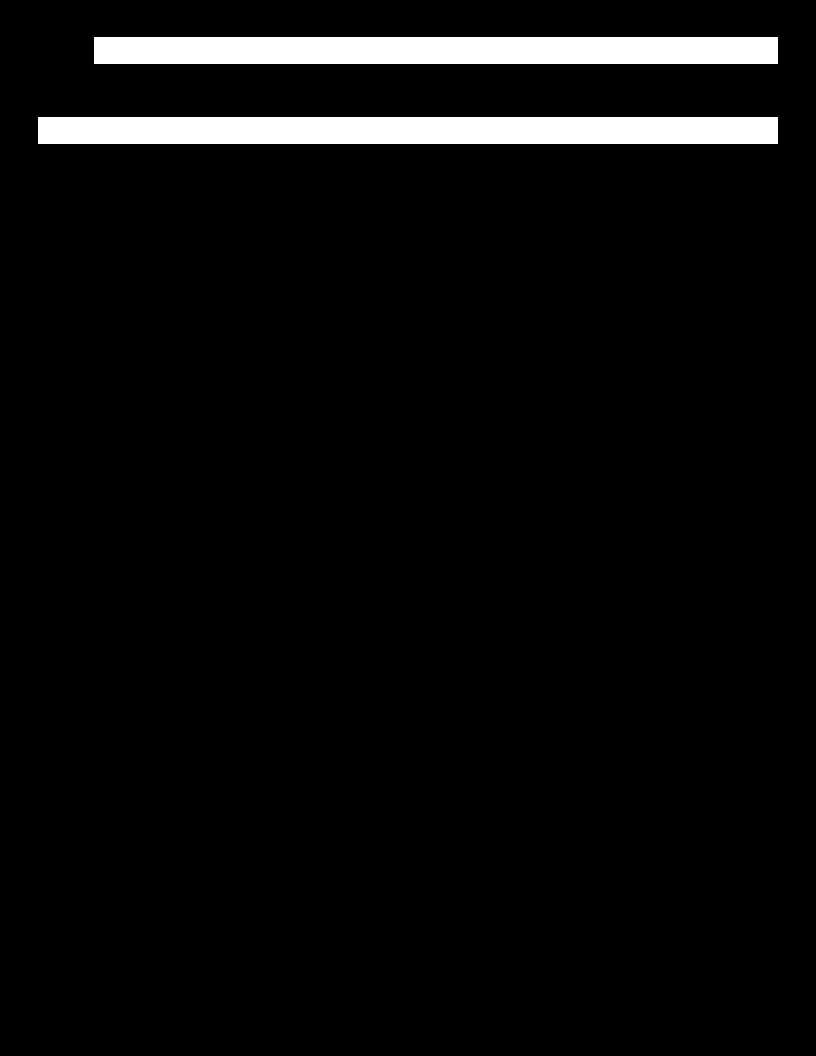

In [41]:
mask_image